Brouillon

Similarité calculé sur 16 dimensions encodées

# XGBoost OOD Test: Hidden Product Names

**Objective**: Test XGBoost robustness on out-of-distribution scenarios by hiding specific product names during training.
- Scenario 0: Baseline - Random split (IID)
- Scenario 1: Hide Similar Product Names (OOD)
- Scenario 2: Hide Dissimilar Product Names (OOD)

## 1. Import Required Libraries

In [ ]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go
from src.features import get_simplified_names
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
print(" Libraries imported successfully")

 Using device: cuda
 Libraries imported successfully


## 2. Load and Prepare Data - Separate Sources for Rigorous OOD Testing

**Méthodologie**:
- **Training Data**: IA_only (source='Donnees_IA', OOD=0) - IID données
- **Test IID Baseline**: IA_only (80/20 split) - Performance de référence
- **Test OOD**: Feedtable_only (source='Feedtable', OOD=1) - Généralisation pure

Cette approche garantit une séparation totale entre les sources d'entraînement et OOD test

In [4]:
# ===== Charger les 3 versions d'embeddings =====
DATA_DIR = '../data/'

data_sources = {
    'IA_only': {
        'embeddings_unique': np.load(DATA_DIR + 'embeddings_IA_only_unique.npy'),
        'embeddings_all': np.load(DATA_DIR + 'embeddings_IA_only_all.npy'),
        'data': pd.read_excel(DATA_DIR + 'data_IA_only_with_embeddings_index.xlsx'),
    },
    'Feedtable_only': {
        'embeddings_unique': np.load(DATA_DIR + 'embeddings_Feedtable_only_unique.npy'),
        'embeddings_all': np.load(DATA_DIR + 'embeddings_Feedtable_only_all.npy'),
        'data': pd.read_excel(DATA_DIR + 'data_Feedtable_only_with_embeddings_index.xlsx'),
    },
    'Combined': {
        'embeddings_unique': np.load(DATA_DIR + 'embeddings_combined_unique.npy'),
        'embeddings_all': np.load(DATA_DIR + 'embeddings_combined_all.npy'),
        'data': pd.read_excel(DATA_DIR + 'data_combined_with_embeddings_index.xlsx'),
    }
}

print(f" Data loaded (all 3 versions)")
for version_name, data in data_sources.items():
    print(f"  - {version_name}: embeddings {data['embeddings_all'].shape}, data shape {data['data'].shape}")

# ===== Utiliser Combined pour avoir accès aux colonnes source/OOD =====
df_ia_only = data_sources['IA_only']['data']

# Charger embeddings originaux (768 dim)
embeddings_combined = data_sources['IA_only']['embeddings_all']

print(f"\n Merged data shape: {df_ia_only.shape}")
print(f" Embeddings shape: {embeddings_combined.shape}")

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut", "EM porc croissance (kcal) kcal/kg brut",
    "EN porc croissance (kcal) kcal/kg brut", "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut", "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

simplified_names = get_simplified_names()

 Data loaded (all 3 versions)
  - IA_only: embeddings (6352, 768), data shape (6352, 28)
  - Feedtable_only: embeddings (122, 768), data shape (122, 28)
  - Combined: embeddings (6550, 768), data shape (6550, 28)

 Merged data shape: (6352, 28)
 Embeddings shape: (6352, 768)


## 2b. Define Autoencoder for Embedding Reduction (768 → 16 dimensions)

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_dim=768, z_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 384),
            nn.ReLU(),
            nn.LayerNorm(384),
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim)
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, out_dim=768, z_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 384),
            nn.ReLU(),
            nn.LayerNorm(384),
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, out_dim)
        )

    def forward(self, z):
        return self.net(z)


class MirrorAutoEncoder(nn.Module):
    def __init__(self, in_dim=768, z_dim=16):
        super().__init__()
        self.encoder = Encoder(in_dim, z_dim)
        self.decoder = Decoder(in_dim, z_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


class FrozenEncoder(nn.Module):
    """Frozen encoder for inference-only (weights not trainable)."""
    def __init__(self, trained_encoder: nn.Module):
        super().__init__()
        self.encoder = trained_encoder
        # Freeze all weights
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.encoder.eval()

    def forward(self, x):
        with torch.no_grad():
            return self.encoder(x)


print(" Autoencoder classes defined")

 Autoencoder classes defined


## 2c. Train Autoencoder on Embeddings

In [6]:
# Split embeddings (60/20/20) for training
X_emb_train, X_emb_temp = train_test_split(
    embeddings_combined, test_size=0.4, random_state=42
)
X_emb_val, X_emb_test = train_test_split(
    X_emb_temp, test_size=0.5, random_state=42
)

# Scale embeddings (fit only on training data)
scaler_emb = StandardScaler()
X_emb_train_scaled = scaler_emb.fit_transform(X_emb_train)
X_emb_val_scaled = scaler_emb.transform(X_emb_val)
X_emb_test_scaled = scaler_emb.transform(X_emb_test)

# Create PyTorch tensors and dataloaders
train_dataset_ae = TensorDataset(
    torch.FloatTensor(X_emb_train_scaled), 
    torch.FloatTensor(X_emb_train_scaled)
)
val_dataset_ae = TensorDataset(
    torch.FloatTensor(X_emb_val_scaled), 
    torch.FloatTensor(X_emb_val_scaled)
)

train_loader_ae = DataLoader(train_dataset_ae, batch_size=32, shuffle=True)
val_loader_ae = DataLoader(val_dataset_ae, batch_size=32, shuffle=False)

# Initialize and train autoencoder
model_autoencoder = MirrorAutoEncoder(in_dim=768, z_dim=16).to(device)
optimizer_ae = optim.AdamW(model_autoencoder.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_ae = F.smooth_l1_loss

print(f" Training Autoencoder (768 → 16 dimensions)...")

num_epochs = 200
patience = 30
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    # Train
    model_autoencoder.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader_ae:
        X_batch = X_batch.to(device)
        optimizer_ae.zero_grad()
        x_hat, _ = model_autoencoder(X_batch)
        loss = criterion_ae(x_hat, X_batch)
        loss.backward()
        optimizer_ae.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader_ae.dataset)
    
    # Validate
    model_autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_ae:
            X_batch = X_batch.to(device)
            x_hat, _ = model_autoencoder(X_batch)
            loss = criterion_ae(x_hat, X_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader_ae.dataset)
    
    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1:3d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_ae_state = model_autoencoder.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            model_autoencoder.load_state_dict(best_ae_state)
            break

print(f" Autoencoder training complete")

 Training Autoencoder (768 → 16 dimensions)...
  Epoch  20: Train Loss=0.0000, Val Loss=0.0000
  Epoch  40: Train Loss=0.0001, Val Loss=0.0001
  Epoch  60: Train Loss=0.0000, Val Loss=0.0000
  Epoch  80: Train Loss=0.0002, Val Loss=0.0002

Early stopping at epoch 98
 Autoencoder training complete


## 2d. Encode Embeddings Using Trained Autoencoder

In [7]:
# ===== Encode embeddings using the trained autoencoder =====
# Create frozen encoder for inference
frozen_encoder = FrozenEncoder(model_autoencoder.encoder).to(device)

X_emb_ia = data_sources['IA_only']['embeddings_all']
X_vars_ia = data_sources['IA_only']['data'][vars_expl].values  # Variables chimiques

# 2. Mise à l'échelle (Inférence avec le scaler fitté sur le train)
X_emb_ia_scaled = scaler_emb.transform(X_emb_ia)
X_emb_ia_tensor_scaled = torch.FloatTensor(X_emb_ia_scaled).to(device)

# 3. Encodage via l'Autoencoder (768 -> 16)
frozen_encoder.eval() # Sécurité
with torch.no_grad():
    X_emb_ia_encoded = frozen_encoder(X_emb_ia_tensor_scaled).cpu().numpy()

# 4. Concaténation avec les 10 variables explicatives
X_combined_ia_encoded = np.hstack([X_emb_ia_encoded, X_vars_ia])

y_ia = data_sources['IA_only']['data'][vars_cibles].values

print(f" Embeddings IA encodés : {X_emb_ia_encoded.shape}")
print(f" Matrice finale (IA) : {X_combined_ia_encoded.shape} (16 latent + 10 variables)")

 Embeddings IA encodés : (6352, 16)
 Matrice finale (IA) : (6352, 26) (16 latent + 10 variables)


In [10]:
# ===== Compute global similarity metric on encoded embeddings (16D) =====
# Use only IA data to identify reference similar/dissimilar pairs
X_emb_ia_unique = np.unique(X_emb_ia_encoded, axis=0)
unique_products_ia = df_ia_only['Nom'].unique()
noms_ia = df_ia_only['Nom'].values

print(f"\n Computing global similarity on encoded embeddings (16D)...")
print(f"  - Unique IA products: {len(unique_products_ia)}")

# Get indices in X_emb_ia_encoded for each unique product (take first occurrence)
unique_indices = []
for nom in unique_products_ia:
    idx = np.where(noms_ia == nom)[0][0]
    unique_indices.append(idx)


 Computing global similarity on encoded embeddings (16D)...
  - Unique IA products: 73


In [11]:
# Compute distances betweeen all unique products
distances = cdist(X_emb_ia_encoded[unique_indices], X_emb_ia_encoded[unique_indices], metric='cosine')
np.fill_diagonal(distances, np.nan)

# Calculer la distance de chaque produit vers TOUS les autres
# distances matrice (n_produits x n_produits)
mean_distances = np.nanmean(distances, axis=1)

# Trouver le produit le plus "central" (le moins isolé)
idx_central = np.argmin(mean_distances)
nom_central = unique_products_ia[idx_central]

# Trouver le produit le plus "isolé" (l'outlier sémantique)
idx_isole = np.argmax(mean_distances)
nom_isole = unique_products_ia[idx_isole]

print(f"Produit le plus 'standard' : {nom_central} (Dist moyenne: {mean_distances[idx_central]:.4f})")
print(f"Produit le plus 'isolé' : {nom_isole} (Dist moyenne: {mean_distances[idx_isole]:.4f})")

nom_similar_1 = nom_central
nom_dissimilar_1 = nom_isole

Produit le plus 'standard' : Tourteau d'arachide, huile < 5 %, cellulose brute > 9 %  (Dist moyenne: 0.7090)
Produit le plus 'isolé' : Mélasse de canne ou de betterave (Dist moyenne: 1.1240)


## 4. Helper Functions for Model Training & Evaluation

In [12]:
def train_xgboost_multioutput(X_train, X_test, y_train, y_test, target_cols):
    """
    Train XGBoost models for each target variable.
    
    Returns: results_df, y_pred, models
    """
    models = {}
    y_pred_all = []
    results = []
    
    for i, target in enumerate(target_cols):
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=0
        )
        
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[:, i], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred))
        r2 = r2_score(y_test[:, i], y_pred)
        
        results.append({
            'Target': simplified_names.get(target, target),
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4)
        })
        
        models[target] = model
        y_pred_all.append(y_pred)
    
    y_pred_all = np.column_stack(y_pred_all)
    
    # Global metrics
    r2_uniform = r2_score(y_test, y_pred_all, multioutput='uniform_average')
    r2_weighted = r2_score(y_test, y_pred_all, multioutput='variance_weighted')
    
    results_df = pd.DataFrame(results)
    
    metrics_global = {
        'R2_uniform': round(r2_uniform, 4),
        'R2_weighted': round(r2_weighted, 4),
        'R2_mean': round(results_df['R2'].mean(), 4),
        'R2_std': round(results_df['R2'].std(), 4),
        'MAE_mean': round(results_df['MAE'].mean(), 2),
        'RMSE_mean': round(results_df['RMSE'].mean(), 2),
    }
    
    return results_df, y_pred_all, models, metrics_global


def print_scenario_results(scenario_name, results_df, metrics_global, y_test, y_pred):
    """Print formatted results for a scenario."""
    print("\n" + "="*80)
    print(f"{scenario_name}")
    print("="*80)
    
    print(f"\nPer-target metrics:")
    print(f"{'Target':<30} {'MAE':<12} {'RMSE':<12} {'R²':<10}")
    print("-" * 80)
    for _, row in results_df.iterrows():
        print(f"{row['Target']:<30} {row['MAE']:<12.2f} {row['RMSE']:<12.2f} {row['R2']:<10.4f}")
    
    print(f"\nGlobal metrics:")
    print(f"  R² (uniform average):     {metrics_global['R2_uniform']:.4f}")
    print(f"  R² (variance weighted):   {metrics_global['R2_weighted']:.4f}")
    print(f"  R² mean (per-target):     {metrics_global['R2_mean']:.4f} ± {metrics_global['R2_std']:.4f}")
    print(f"  MAE mean:                 {metrics_global['MAE_mean']:.2f}")
    print(f"  RMSE mean:                {metrics_global['RMSE_mean']:.2f}")

## 5. Scenario 0: Baseline - Random Split (IID)

In [13]:
# ===== SCENARIO 0: Baseline IID =====
# Random train/test split within IA_only data (80/20)
X_train_s0, X_test_s0, y_train_s0, y_test_s0 = train_test_split(
    X_combined_ia_encoded, y_ia, test_size=0.2, random_state=42
)

# Normalize features
scaler_s0 = StandardScaler()
X_train_s0 = scaler_s0.fit_transform(X_train_s0)
X_test_s0 = scaler_s0.transform(X_test_s0)

print(f"\n{'='*80}")
print(f"SCENARIO 0: Baseline IID (IA_only data, random 80/20 split)")
print(f"{'='*80}")
print(f"  Train: {X_train_s0.shape[0]} samples")
print(f"  Test:  {X_test_s0.shape[0]} samples")

# Train models
results_s0, y_pred_s0, models_s0, metrics_s0 = train_xgboost_multioutput(
    X_train_s0, X_test_s0, y_train_s0, y_test_s0, vars_cibles
)

print_scenario_results("SCENARIO 0: Baseline (IID - Random Split on IA_only)", results_s0, metrics_s0, y_test_s0, y_pred_s0)


SCENARIO 0: Baseline IID (IA_only data, random 80/20 split)
  Train: 5081 samples
  Test:  1271 samples

SCENARIO 0: Baseline (IID - Random Split on IA_only)

Per-target metrics:
Target                         MAE          RMSE         R²        
--------------------------------------------------------------------------------
EB                             27.27        45.23        0.9947    
ED porc                        45.02        74.69        0.9921    
EM porc                        40.90        70.49        0.9924    
EN porc                        32.23        52.97        0.9944    
EMAn coq                       48.58        73.99        0.9919    
EMAn poulet                    48.85        74.18        0.9914    
UFL                            0.02         0.03         0.9909    
UFV                            0.02         0.03         0.9910    
PDIA                           1.43         3.15         0.9984    
PDI                            1.64         3.07         0.

## 6. Scenario 1: OOD - Hide Similar Product Names

In [15]:
# ===== SCENARIO 1: OOD Test - Hide Similar Product (within IA data) =====
# Hide the globally most similar product from training
products_to_hide_s1 = {nom_similar_1}

print(f"\n{'='*80}")
print(f"SCENARIO 1: OOD Test - Hide Similar Product (IA_only data)")
print(f"{'='*80}")
print(f"\n Hidden product configuration:")
print(f"  Hide: '{nom_similar_1}'")

# Create train/test split (hiding one product)
mask_train_s1 = df_ia_only['Nom'] != nom_similar_1
mask_test_s1 = df_ia_only['Nom'] == nom_similar_1

# Build feature matrices
X_train_s1 = X_combined_ia_encoded[mask_train_s1]
y_train_s1 = y_ia[mask_train_s1]

X_test_s1 = X_combined_ia_encoded[mask_test_s1]
y_test_s1 = y_ia[mask_test_s1]

# Normalize features
scaler_s1 = StandardScaler()
X_train_s1 = scaler_s1.fit_transform(X_train_s1)
X_test_s1 = scaler_s1.transform(X_test_s1)

print(f"  Train: {X_train_s1.shape[0]} samples (excluding '{nom_similar_1}')")
print(f"  Test:  {X_test_s1.shape[0]} samples (OOD - similar product hidden)")

# Train models
results_s1, y_pred_s1, models_s1, metrics_s1 = train_xgboost_multioutput(
    X_train_s1, X_test_s1, y_train_s1, y_test_s1, vars_cibles
)

print_scenario_results("SCENARIO 1: OOD Test - Similar Product Hidden (within IA_only)", results_s1, metrics_s1, y_test_s1, y_pred_s1)



SCENARIO 1: OOD Test - Hide Similar Product (IA_only data)

 Hidden product configuration:
  Hide: 'Tourteau d'arachide, huile < 5 %, cellulose brute > 9 % '
  Train: 6252 samples (excluding 'Tourteau d'arachide, huile < 5 %, cellulose brute > 9 % ')
  Test:  100 samples (OOD - similar product hidden)

SCENARIO 1: OOD Test - Similar Product Hidden (within IA_only)

Per-target metrics:
Target                         MAE          RMSE         R²        
--------------------------------------------------------------------------------
EB                             114.13       122.34       -0.9851   
ED porc                        72.91        90.11        0.7544    
EM porc                        97.96        108.65       0.5848    
EN porc                        38.65        50.75        0.7611    
EMAn coq                       576.82       581.48       -38.6422  
EMAn poulet                    516.17       520.74       -32.4442  
UFL                            0.10         0.12      

## 7. Scenario 2: OOD - Hide Dissimilar Product Names

In [16]:
# ===== SCENARIO 2: Pure OOD Test - Train on IA, Test on ISOLATED Product =====
print(f"\n{'='*80}")
print(f"SCENARIO 2: Robustness Test - Train IA, Test on Isolated Product")
print(f"{'='*80}")

# 1. Utiliser le nom du produit ISOLÉ (celui qu'on a trouvé avec la distance moyenne max)
nom_a_tester = nom_isole 

print(f"  Testing on ISOLATED product: '{nom_a_tester}'")
print(f"  Average semantic distance: {mean_distances[idx_isole]:.4f}")

# 2. Création des masques sur le dataset IA
mask_train_s2 = df_ia_only['Nom'] != nom_a_tester
mask_test_s2 = df_ia_only['Nom'] == nom_a_tester

# 3. Extraction des données (on reste sur la matrice IA qui est cohérente)
X_train_s2 = X_combined_ia_encoded[mask_train_s2]
y_train_s2 = y_ia[mask_train_s2]

X_test_s2 = X_combined_ia_encoded[mask_test_s2]
y_test_s2 = y_ia[mask_test_s2]

# 4. Normalisation
scaler_s2 = StandardScaler()
X_train_s2 = scaler_s2.fit_transform(X_train_s2)
X_test_s2 = scaler_s2.transform(X_test_s2)

print(f"  Train: {X_train_s2.shape[0]} samples")
print(f"  Test:  {X_test_s2.shape[0]} samples (Product '{nom_a_tester}')")

# 5. Train & Evaluate
results_s2, y_pred_s2, models_s2, metrics_s2 = train_xgboost_multioutput(
    X_train_s2, X_test_s2, y_train_s2, y_test_s2, vars_cibles
)

print_scenario_results("SCENARIO 2: Stress Test (Isolated IA Product)", results_s2, metrics_s2, y_test_s2, y_pred_s2)


SCENARIO 2: Robustness Test - Train IA, Test on Isolated Product
  Testing on ISOLATED product: 'Mélasse de canne ou de betterave'
  Average semantic distance: 1.1240
  Train: 6252 samples
  Test:  100 samples (Product 'Mélasse de canne ou de betterave')

SCENARIO 2: Stress Test (Isolated IA Product)

Per-target metrics:
Target                         MAE          RMSE         R²        
--------------------------------------------------------------------------------
EB                             555.34       562.28       -12.0216  
ED porc                        500.31       508.09       -13.6743  
EM porc                        271.64       286.60       -3.9041   
EN porc                        660.98       663.36       -58.9953  
EMAn coq                       268.66       324.62       -0.9556   
EMAn poulet                    274.43       331.94       -1.0448   
UFL                            0.21         0.21         -23.8910  
UFV                            0.23         0.23   

## 8. Compare R² Across Scenarios


SCENARIO COMPARISON - SEMANTIC ROBUSTNESS ANALYSIS

                  Scenario  R2_weighted  R2_mean  MAE_mean  RMSE_mean
   Baseline IID (IA 80/20)       0.9927   0.9940     22.59      36.52
 OOD Similar (Hidden Peer)      -5.7426 -12.7116    139.96     146.82
OOD Isolated (Stress Test)      -6.5451 -60.5543    235.18     248.65

Performance Drop from Baseline (IID):
  Similar OOD (Peer exists):      -5.7426 (Δ = +6.7353, +678.5%)
  Isolated OOD (Stress Test):     -6.5451 (Δ = +7.5378, +759.3%)



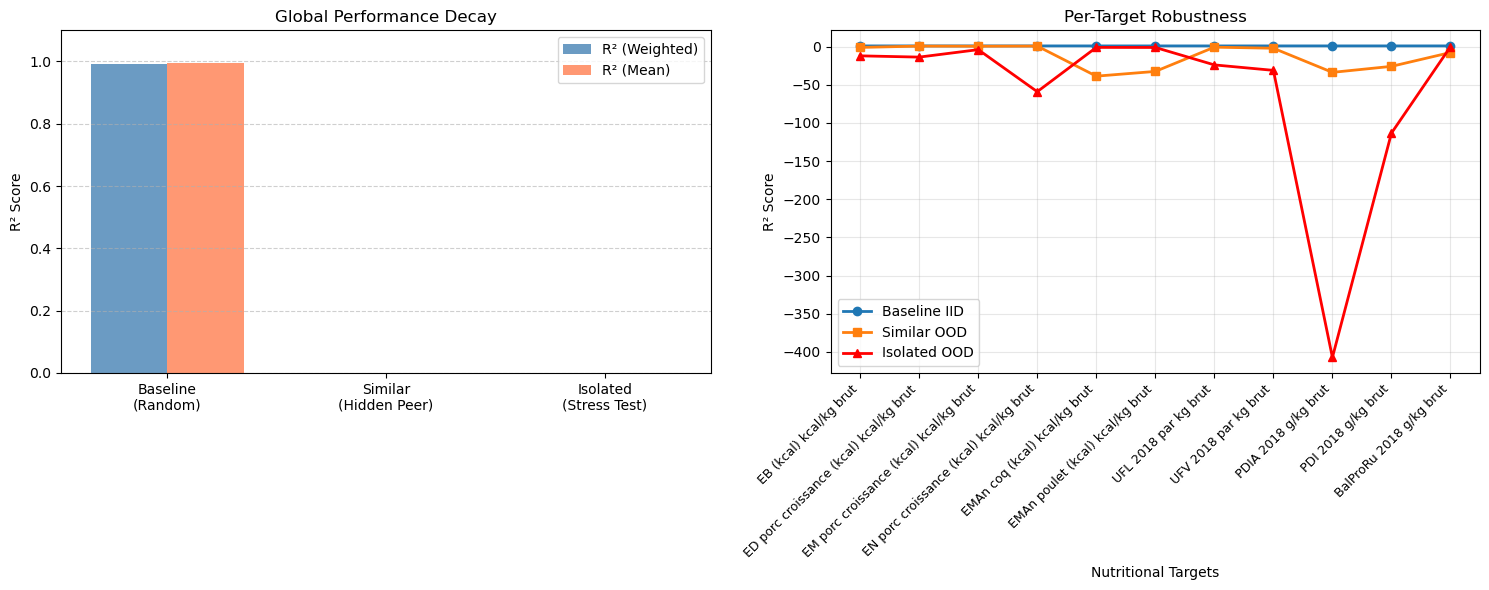

In [17]:
print("\n" + "="*80)
print("SCENARIO COMPARISON - SEMANTIC ROBUSTNESS ANALYSIS")
print("="*80)

# 1. Mise à jour des noms de scénarios pour correspondre à ta nouvelle stratégie
scenarios_info = [
    ("Baseline IID (IA 80/20)", results_s0, metrics_s0, "IID"),
    ("OOD Similar (Hidden Peer)", results_s1, metrics_s1, "SIMILAR"),
    ("OOD Isolated (Stress Test)", results_s2, metrics_s2, "ISOLATED")
]

comparison_data = []
for name, results_df, metrics, _ in scenarios_info:
    comparison_data.append({
        'Scenario': name,
        'R2_weighted': metrics['R2_weighted'],
        'R2_mean': metrics['R2_mean'],
        'MAE_mean': metrics['MAE_mean'],
        'RMSE_mean': metrics['RMSE_mean']
        # Note: n_train ici dépend de la taille du train dans chaque scénario
    })

comparison_df = pd.DataFrame(comparison_data)
print(f"\n{comparison_df.to_string(index=False)}")

# 2. Calcul des chutes de performance (Performance Drops)
baseline_r2 = metrics_s0['R2_weighted']
drop_s1 = baseline_r2 - metrics_s1['R2_weighted']
drop_s2 = baseline_r2 - metrics_s2['R2_weighted']

print(f"\n{'='*80}")
print(f"Performance Drop from Baseline (IID):")
print(f"{'='*80}")
print(f"  Similar OOD (Peer exists):      {metrics_s1['R2_weighted']:.4f} (Δ = {drop_s1:+.4f}, {drop_s1/baseline_r2*100:+.1f}%)")
print(f"  Isolated OOD (Stress Test):     {metrics_s2['R2_weighted']:.4f} (Δ = {drop_s2:+.4f}, {drop_s2/baseline_r2*100:+.1f}%)")

print(f"\n{'='*80}")

# 3. Visualisation R² Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: R² global par scénario
labels = ["Baseline\n(Random)", "Similar\n(Hidden Peer)", "Isolated\n(Stress Test)"]
x = np.arange(len(labels))
width = 0.35

axes[0].bar(x - width/2, [m['R2_weighted'] for _,_,m,_ in scenarios_info], 
            width, label='R² (Weighted)', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, [m['R2_mean'] for _,_,m,_ in scenarios_info], 
            width, label='R² (Mean)', color='coral', alpha=0.8)

axes[0].set_ylabel('R² Score')
axes[0].set_title('Global Performance Decay')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylim(0, 1.1)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Plot 2: Per-target R² (Utilise les vrais noms de colonnes maintenant !)
x_targets = np.arange(len(vars_cibles))

axes[1].plot(x_targets, results_s0['R2'].values, 'o-', label='Baseline IID', linewidth=2)
axes[1].plot(x_targets, results_s1['R2'].values, 's-', label='Similar OOD', linewidth=2)
axes[1].plot(x_targets, results_s2['R2'].values, '^-', label='Isolated OOD', linewidth=2, color='red')

axes[1].set_xlabel('Nutritional Targets')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Per-Target Robustness')
axes[1].set_xticks(x_targets)
# Rotation des noms pour la lisibilité
axes[1].set_xticklabels(vars_cibles, rotation=45, ha='right', fontsize=9)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Visualize True vs Predicted Values

In [18]:
def plot_comparison_robustness(results_s1, y_test_s1, y_pred_s1, results_s2, y_test_s2, y_pred_s2):
    """
    Affiche la comparaison True vs Pred entre le cas 'Proche' et le cas 'Isolé'.
    """
    n_targets = len(vars_cibles)
    rows = (n_targets + 3) // 4
    
    fig = sp.make_subplots(
        rows=rows, cols=4,
        subplot_titles=[f"<b>{t.split(' (')[0]}</b>" for t in vars_cibles],
        vertical_spacing=0.1
    )

    for i in range(n_targets):
        row = i // 4 + 1
        col = i % 4 + 1
        
        # --- CAS 1 : PRODUIT PROCHE (SIMILAIRE) ---
        fig.add_trace(
            go.Scatter(
                x=y_test_s1[:, i], y=y_pred_s1[:, i],
                mode='markers',
                marker=dict(color='mediumseagreen', size=10, symbol='circle',
                            line=dict(width=1, color='white')),
                name='Proche (S1)',
                legendgroup='S1',
                showlegend=(i == 0),
                hovertemplate='<b>Proche (S1)</b><br>Vrai: %{x:.2f}<br>Pred: %{y:.2f}<extra></extra>'
            ),
            row=row, col=col
        )

        # --- CAS 2 : PRODUIT ÉLOIGNÉ (ISOLÉ) ---
        fig.add_trace(
            go.Scatter(
                x=y_test_s2[:, i], y=y_pred_s2[:, i],
                mode='markers',
                marker=dict(color='crimson', size=10, symbol='x',
                            line=dict(width=1, color='white')),
                name='Éloigné (S2)',
                legendgroup='S2',
                showlegend=(i == 0),
                hovertemplate='<b>Éloigné (S2)</b><br>Vrai: %{x:.2f}<br>Pred: %{y:.2f}<extra></extra>'
            ),
            row=row, col=col
        )

        # --- LIGNE DE RÉFÉRENCE Y=X ---
        # On calcule les limites pour que la ligne s'adapte aux deux points
        combined = np.concatenate([y_test_s1[:, i], y_pred_s1[:, i], y_test_s2[:, i], y_pred_s2[:, i]])
        m_val, M_val = np.min(combined) * 0.98, np.max(combined) * 1.02
        
        fig.add_trace(
            go.Scatter(x=[m_val, M_val], y=[m_val, M_val], mode='lines',
                       line=dict(color='rgba(0,0,0,0.2)', dash='dot'),
                       showlegend=False, hoverinfo='skip'),
            row=row, col=col
        )

    fig.update_layout(
        height=300 * rows, width=1300,
        title_text="<b>Comparaison de Robustesse</b> : Produit Similaire (Vert) vs Produit Isolé (Rouge)",
        template='plotly_white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    return fig

# Lancement de la visualisation
fig_robustness = plot_comparison_robustness(
    results_s1, y_test_s1, y_pred_s1, 
    results_s2, y_test_s2, y_pred_s2
)
fig_robustness.show()

In [30]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

results_lopo = []
all_y_true = []
all_y_pred = []

# On s'assure que la diagonale est à 0 pour ne pas se comparer à soi-même
np.fill_diagonal(sim_matrix, 0)

print(f"Lancement de l'analyse sur {len(unique_products_ia)} produits...")

for i, nom_test in enumerate(unique_products_ia):
    # 1. Calcul de l'isolement et du voisinage
    sims_ce_produit = sim_matrix[i]
    dist_semantique = 1 - np.max(sims_ce_produit)
    
    # Volume de données chez les 3 voisins les plus proches
    idx_voisins = np.argsort(sims_ce_produit)[-3:]
    volume_voisinage = sum([len(df_ia_only[df_ia_only['Nom'] == unique_products_ia[iv]]) for iv in idx_voisins])
    
    # 2. Split Train/Test
    mask_test = df_ia_only['Nom'] == nom_test
    mask_train = ~mask_test
    
    X_train, y_train = X_combined_ia_encoded[mask_train], y_ia[mask_train]
    X_test, y_test = X_combined_ia_encoded[mask_test], y_ia[mask_test]
    
    # 3. Training & Prediction
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, verbosity=0, random_state=42)
    model.fit(X_train_s, y_train)
    y_p = model.predict(X_test_s)
    
    # Stockage pour le R2 global plus tard
    all_y_true.append(y_test)
    all_y_pred.append(y_p)
    
    # 4. Métriques par cible pour ce produit
    err_abs = y_p - y_test
    # Erreur relative par cible
    err_rel_targets = np.mean(np.abs(err_abs) / (np.abs(y_test) + 1e-9), axis=0) * 100
    
    # R2 par cible (peut être NaN si 1 seule ligne, c'est géré)
    r2_targets = []
    for col in range(y_test.shape[1]):
        if len(y_test) > 1 and np.std(y_test[:, col]) > 0:
            r2_targets.append(r2_score(y_test[:, col], y_p[:, col]))
        else:
            r2_targets.append(np.nan)

    results_lopo.append({
        'Produit': nom_test,
        'Distance_Semantique': dist_semantique,
        'Volume_Voisinage': volume_voisinage,
        'Nb_Echantillons_Test': len(y_test),
        'Erreur_Relative_Pct': np.mean(err_rel_targets),
        'Errors_Per_Target': err_rel_targets,
        'R2_Per_Target': r2_targets,
        'Bias_Per_Target': np.mean(err_abs, axis=0)
    })
    
    if (i+1) % 10 == 0: print(f"Progress: {i+1}/{len(unique_products_ia)} | Dernier : {nom_test}")

df_lopo = pd.DataFrame(results_lopo)

# 5. CALCUL DU R² GLOBAL (Le seul vrai juge)
y_true_all = np.vstack(all_y_true)
y_pred_all = np.vstack(all_y_pred)
r2_globaux = r2_score(y_true_all, y_pred_all, multioutput='raw_values')

print("\n" + "="*40)
print(" SYNTHÈSE DES R² GLOBAUX PAR CIBLE")
print("="*40)
for name, r2 in zip(vars_cibles, r2_globaux):
    print(f"{name.split(' (')[0]:<20} : {r2:.4f}")

Lancement de l'analyse sur 73 produits...
Progress: 10/73 | Dernier : Farine basse de blé tendre 
Progress: 20/73 | Dernier : Maïs 
Progress: 30/73 | Dernier : Son de blé tendre 
Progress: 40/73 | Dernier : Tourteau de soja, huile < 5 %, 48 % protéine + huile 
Progress: 50/73 | Dernier : Son de maïs
Progress: 60/73 | Dernier : Tourteau de coton, huile 5-20 %
Progress: 70/73 | Dernier : Lactosérum écrèmé déshydraté (doux ou acide)

 SYNTHÈSE DES R² GLOBAUX PAR CIBLE
EB                   : 0.8780
ED porc croissance   : 0.8169
EM porc croissance   : 0.8052
EN porc croissance   : 0.8665
EMAn coq             : 0.7910
EMAn poulet          : 0.7680
UFL 2018 par kg brut : 0.6836
UFV 2018 par kg brut : 0.6744
PDIA 2018 g/kg brut  : 0.6055
PDI 2018 g/kg brut   : 0.6147
BalProRu 2018 g/kg brut : 0.7513


In [32]:
import plotly.graph_objects as go

# Calcul des moyennes pour l'affichage
mean_err = df_lopo['Erreur_Relative_Pct'].mean()
median_err = df_lopo['Erreur_Relative_Pct'].median()

# Tableau récapitulatif par cible
summary_df = pd.DataFrame({
    'Cible': [v.split(' (')[0] for v in vars_cibles],
    'R2_Global': r2_globaux,
    'Erreur_Relative_Moyenne_%': np.mean(df_lopo['Errors_Per_Target'].tolist(), axis=0)
}).sort_values('R2_Global', ascending=False)

print("="*50)
print(f" PERFORMANCE MOYENNE (LOPO-CV)")
print(f"Erreur Relative Moyenne : {mean_err:.2f}%")
print(f"Médiane de l'Erreur     : {median_err:.2f}%")
print("="*50)
print(summary_df.to_string(index=False))

 PERFORMANCE MOYENNE (LOPO-CV)
Erreur Relative Moyenne : 27.47%
Médiane de l'Erreur     : 16.30%
                  Cible  R2_Global  Erreur_Relative_Moyenne_%
                     EB   0.877956                   3.339434
     EN porc croissance   0.866465                  11.647545
     ED porc croissance   0.816944                  10.135725
     EM porc croissance   0.805170                  10.618571
               EMAn coq   0.790965                  15.150423
            EMAn poulet   0.767980                  15.663415
BalProRu 2018 g/kg brut   0.751334                 101.675322
   UFL 2018 par kg brut   0.683574                  16.637627
   UFV 2018 par kg brut   0.674371                  23.542616
     PDI 2018 g/kg brut   0.614737                  21.445669
    PDIA 2018 g/kg brut   0.605485                  72.354265


In [40]:
import plotly.express as px

fig_bubble = px.scatter(
    df_lopo, 
    x="Distance_Semantique", 
    y="Erreur_Relative_Pct",
    size="Volume_Voisinage", 
    color="Erreur_Relative_Pct",
    hover_name="Produit",
    size_max=10,
    color_continuous_scale="Reds",
    trendline="ols",
    title="<b>Diagnostic de Robustesse</b> : L'erreur est-elle liée à l'isolement du produit ?",
    labels={"Distance_Semantique": "Isolement du Nom (1 - Cosine)", "Erreur_Relative_Pct": "Erreur Moyenne (%)"},
    template="plotly_white"
)
fig_bubble.show()

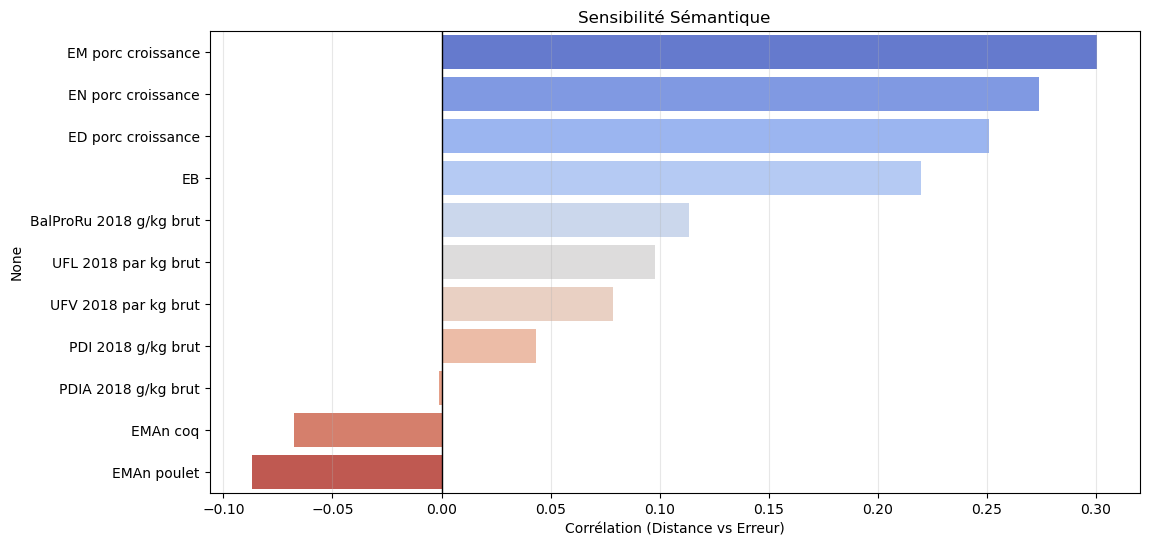

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données de corrélation
df_corr = pd.DataFrame(df_lopo['Errors_Per_Target'].tolist(), columns=[v.split(' (')[0] for v in vars_cibles])
df_corr['Dist'] = df_lopo['Distance_Semantique']
sensibility_series = df_corr.corr()['Dist'].drop('Dist').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=sensibility_series.values, y=sensibility_series.index, palette="coolwarm")
plt.axvline(0, color='black', lw=1)
plt.title("Sensibilité Sémantique")
plt.xlabel("Corrélation (Distance vs Erreur)")
plt.grid(axis='x', alpha=0.3)
plt.show()

In [36]:
top_5 = df_lopo.nsmallest(5, 'Erreur_Relative_Pct')[['Produit', 'Erreur_Relative_Pct', 'Distance_Semantique']]
flop_5 = df_lopo.nlargest(5, 'Erreur_Relative_Pct')[['Produit', 'Erreur_Relative_Pct', 'Distance_Semantique']]

print("\n TOP 5 - Produits les plus robustes :")
print(top_5.to_string(index=False))

print("\n FLOP 5 - Produits les plus problématiques :")
print(flop_5.to_string(index=False))


 TOP 5 - Produits les plus robustes :
                                              Produit  Erreur_Relative_Pct  Distance_Semantique
Tourteau de soja, huile < 5 %, 48 % protéine + huile              4.174803             0.112404
         Drêches de blé de distillerie, amidon < 7 %              4.651402             0.045191
Tourteau de soja, huile < 5 %, 50 % protéine + huile              5.523574             0.112404
                            Farine fourragère de maïs             5.895873             0.175562
                                           Triticale              6.146029             0.436800

 FLOP 5 - Produits les plus problématiques :
                         Produit  Erreur_Relative_Pct  Distance_Semantique
            Vinasse de levurerie           139.729158             0.355433
Mélasse de canne ou de betterave           134.372824             0.153886
             Farine basse de riz            95.216217             0.343271
                         Avoine        

In [37]:
import plotly.subplots as sp
import plotly.graph_objects as go

# 1. On reformate les données agrégées
y_true_final = np.vstack(all_y_true)
y_pred_final = np.vstack(all_y_pred)

# 2. Configuration de la grille (ex: 4 lignes, 3 colonnes pour 11 cibles)
rows, cols = 4, 3
fig = sp.make_subplots(
    rows=rows, cols=cols, 
    subplot_titles=[v.split(' (')[0] for v in vars_cibles],
    vertical_spacing=0.08,
    horizontal_spacing=0.08
)

for i, name in enumerate(vars_cibles):
    curr_row = (i // cols) + 1
    curr_col = (i % cols) + 1
    
    # Données pour cette cible
    yt = y_true_final[:, i]
    yp = y_pred_final[:, i]
    
    # Scatter plot
    fig.add_trace(
        go.Scatter(
            x=yt, y=yp, 
            mode='markers',
            marker=dict(size=5, opacity=0.6, color='royalblue'),
            name=name.split(' (')[0],
            showlegend=False
        ),
        row=curr_row, col=curr_col
    )
    
    # Ligne d'identité (x = y)
    min_val = min(yt.min(), yp.min())
    max_val = max(yt.max(), yp.max())
    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val], y=[min_val, max_val],
            mode='lines',
            line=dict(color='red', dash='dash'),
            showlegend=False
        ),
        row=curr_row, col=curr_col
    )
    
    # Labels
    fig.update_xaxes(title_text="Réel", row=curr_row, col=curr_col)
    fig.update_yaxes(title_text="Prédit", row=curr_row, col=curr_col)

fig.update_layout(
    height=1200, width=1100,
    title_text="<b>Validation Croisée LOPO</b> : Valeurs Réelles vs Prédictions par Nutriment",
    template='plotly_white'
)
fig.show()

In [39]:
# 1. Calcul du R2 moyen par produit (en ignorant les NaN)
df_lopo['R2_Moyen_Produit'] = df_lopo['R2_Per_Target'].apply(lambda x: np.nanmean(x) if isinstance(x, list) or isinstance(x, np.ndarray) else np.nan)

# 2. Tri par performance
df_r2_sorted = df_lopo[['Produit', 'R2_Moyen_Produit', 'Erreur_Relative_Pct', 'Distance_Semantique']].sort_values('R2_Moyen_Produit', ascending=False)

print("="*60)
print(f" TOP 10 PRODUITS (Meilleurs R² moyens)")
print("="*60)
print(df_r2_sorted.head(10).to_string(index=False))

print("\n" + "="*60)
print(f" FLOP 10 PRODUITS (Pires R² moyens)")
print("="*60)
print(df_r2_sorted.tail(10).to_string(index=False))

 TOP 10 PRODUITS (Meilleurs R² moyens)
                        Produit  R2_Moyen_Produit  Erreur_Relative_Pct  Distance_Semantique
     Coproduits de biscuiterie           0.597629            15.528119             0.321881
Tourteau de coton, huile 5-20 %          0.489517             7.857498             0.337955
 Tourteau de coton, huile < 5 %          0.243383             8.244496             0.336350
         Lactosérum réengraissé          0.174729            59.407850             0.212472
        Son de riz, huile < 5 %          0.160689            35.610959             0.109731
                            Riz          0.156596             8.256437             0.481438
      Farine fourragère de maïs         -0.000400             5.895873             0.175562
            Farine basse de riz         -0.093096            95.216217             0.343271
        Son de riz, huile > 5 %         -0.094038            31.337487             0.109731
    Farine basse de blé tendre          -